In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Поэтапный подход

### Чтение данных

In [2]:
# data = pd.read_csv('train.csv')
# data['timestamp'] = data['timestamp'].apply(pd.Timestamp)
data = pd.read_csv('train.csv', parse_dates=['timestamp'])
data = data.set_index('id')

### Обработка признаков (Part 1)

In [3]:
ddf = data.dtypes.reset_index()
ddf.columns = ['Count columns', 'Type']
ddf.groupby('Type').count()

,Count columns
Type,
datetime64[ns],1
int64,156
float64,119
object,15


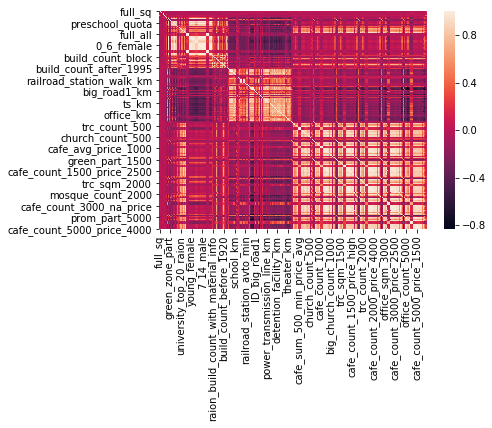

In [4]:
sns.heatmap(data.corr())

#### Обработка временных признаков

In [5]:
data['year'] = data['timestamp'].apply(lambda x: x.year)
data['month'] = data['timestamp'].apply(lambda x: x.month)
data['day'] = data['timestamp'].apply(lambda x: x.day_name())
data = data.drop('timestamp', axis=1)

In [6]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']
ddf.groupby('Type').count()

,cols
Type,
int64,158
float64,119
object,16


### Обработка категориальных значений

In [7]:
data.shape

(30471, 293)

In [8]:
cat_bin_columns = ddf[ddf.Type == 'object'].cols.values

In [9]:
cat_bin_columns

array(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion',
       'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line',
       'big_road1_1line', 'railroad_1line', 'ecology', 'day'],
      dtype=object)

In [10]:
data[cat_bin_columns].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,day
id,,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,Saturday
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent,Tuesday
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor,Saturday
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good,Thursday
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent,Monday


In [12]:
cat_columns = ['product_type', 'sub_area', 'ecology', 'day']
bin_columns = list(set(cat_bin_columns) - set(cat_columns))

In [13]:
data = pd.get_dummies(data, columns=cat_columns)

In [14]:
from sklearn.preprocessing import OrdinalEncoder

In [16]:
lbl = OrdinalEncoder()
data[bin_columns] = lbl.fit_transform(data[bin_columns])

In [17]:
data[bin_columns].head()

,radiation_raion,nuclear_reactor_raion,thermal_power_plant_raion,big_road1_1line,oil_chemistry_raion,big_market_raion,culture_objects_top_25,railroad_1line,water_1line,railroad_terminal_raion,detention_facility_raion,incineration_raion
id,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [18]:
ddf = data.dtypes.reset_index()
ddf.columns = ['Count columns', 'Type']
ddf.groupby('Type').count()

,Count columns
Type,
uint8,160
int64,158
float64,131


### Разделение выборки на Train и Test

In [19]:
from sklearn.model_selection import train_test_split

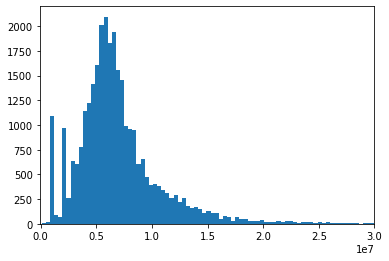

In [20]:
plt.hist(data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])
plt.show()

In [21]:
train_data, test_data  = train_test_split(data, test_size=0.3,
                                          shuffle=True,
                                          random_state=42)
train_data = train_data.copy()
test_data = test_data.copy()

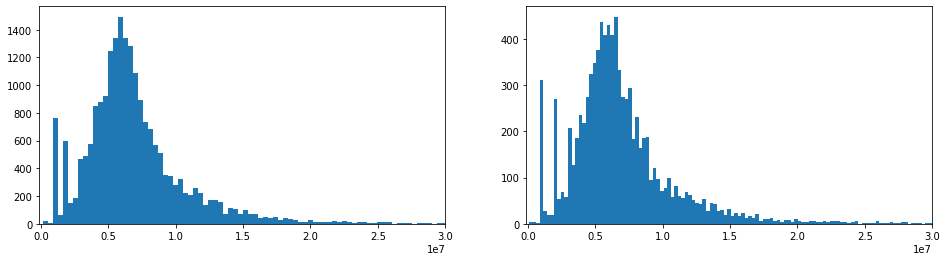

In [22]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.hist(train_data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])

plt.subplot(122)
plt.hist(test_data['price_doc'], bins=300)
plt.xlim([-1e5, 3e7])

plt.show()

In [23]:
y_train = train_data['price_doc']
X_train = train_data.drop('price_doc', axis=1)

y_test = test_data['price_doc']
X_test = test_data.drop('price_doc', axis=1)

### Пропущенные значения

In [25]:
mode = 'fill_zero'

if mode == 'fill_zero':
    null_vals = 0
if mode == 'fill_mean':
    null_vals = X_train.mean()
if mode == 'fill_median':
    null_vals = X_test.median()

X_train = X_train.fillna(null_vals)
X_test = X_test.fillna(null_vals)

### Нормализация

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Модель

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

rmsle = lambda y1, y2: np.sqrt(mean_squared_log_error(y1, y2))

In [29]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred[y_pred<=0] = 1e-8
rmsle(y_test, y_pred)

0.7066032418080341

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
rmsle(y_test, y_pred)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.47827249388273396

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

In [37]:
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
rmsle(y_test, y_pred)

0.47654341731046634

### Подбор параметров

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [53]:
gs = GridSearchCV(estimator=ElasticNet(),
                  param_grid={'alpha': [0.1, 1, 10],
                              'l1_ratio': [0.01, 0.05, 0.1]},
                  scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

In [54]:
gs.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.749194586125971e+17, tolerance: 49978155204679.305
  positive)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'l1_ratio': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [57]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.749194586125971e+17, tolerance: 49978155204679.305
  positive)


ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
y_pred = reg.predict(X_test)
rmsle(y_test, y_pred)

0.5333222859275811

## Pipeline

In [32]:
from sklearn import pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

In [33]:
data = pd.read_csv('train.csv', parse_dates=['timestamp'])
data = data.set_index('id')

data['year'] = data['timestamp'].apply(lambda x: x.year)
data['month'] = data['timestamp'].apply(lambda x: x.month)
data['day'] = data['timestamp'].apply(lambda x: x.day_name())
data = data.drop('timestamp', axis=1)

In [34]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']
ddf.groupby('Type').count()

,cols
Type,
int64,158
float64,119
object,16


In [35]:
cat_boolean_columns = ddf[ddf.Type == 'object'].cols.values
cat_columns = ['product_type', 'sub_area', 'ecology', 'day']
bin_columns = list(set(cat_boolean_columns) - set(cat_columns))
int_columns = ddf[ddf.Type == 'int64'].cols.values
flt_columns = ddf[ddf.Type == 'float64'].cols.values

In [36]:
int_columns = list(set(int_columns) - {'price_doc'})

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
train_data, test_data  = train_test_split(data, test_size=0.3,
                                          shuffle=True,
                                          random_state=42)
train_data = train_data.copy()
test_data = test_data.copy()

In [39]:
y_train = train_data['price_doc']
X_train = train_data.drop('price_doc', axis=1)

y_test = test_data['price_doc']
X_test = test_data.drop('price_doc', axis=1)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler

bin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='no')),
    ('binarized', OrdinalEncoder())])

int_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

flt_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin', bin_transformer, bin_columns),
        ('int', int_transformer, int_columns),
        ('flt', flt_transformer, flt_columns),
        ('cat', cat_transformer, cat_columns)])

In [58]:
estimator = pipeline.Pipeline(steps = [    
    ('preprocessing', preprocessor),       
    ('model', RandomForestRegressor())
    ]
)

In [59]:
estimator.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('bin',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                     

In [61]:
from sklearn.metrics import mean_squared_log_error
rmsle = lambda y1, y2: np.sqrt(mean_squared_log_error(y1, y2))

In [62]:
y_pred = estimator.predict(X_test)
y_pred[y_pred <= 0] = 1e-9
rmsle(y_test, y_pred)

0.4792307231376793

### GridSearch in pipeline

In [63]:
list(filter(lambda x: 'model' in x, estimator.get_params()))

['model',
 'model__bootstrap',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__min_impurity_decrease',
 'model__min_impurity_split',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fraction_leaf',
 'model__n_estimators',
 'model__n_jobs',
 'model__oob_score',
 'model__random_state',
 'model__verbose',
 'model__warm_start']

In [64]:
param_grid = {
    'model__max_depth': [50, 100],
    'model__n_estimators': [10, 20],
}

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
CV = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=4)

In [67]:
CV.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('bin',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                   

In [69]:
best_estimator = CV.best_estimator_

In [70]:
best_estimator.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('bin',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                     

In [72]:
y_pred = best_estimator.predict(X_test)
y_pred[y_pred <= 0] = 1e-9
rmsle(y_test, y_pred)

0.4740462105683255